In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
import time

In [3]:
exe_dir = "/home/aswathy/DATA_ANALYSIS/datalab/code"
data_dir = "/home/aswathy/DATA_ANALYSIS/datalab/solutions/Final_assignment/data"

In [4]:
"""
Usage: ./generate_source  [-h] [-o <file>] [-s <float>] [-d <float>] [-N <int>] [-f <float>] [-p <float>]
                          [-a <float>] [-r <int>]
  -o, --output=<file>       output file
  -s, --sigma=<float>       standard deviation sigma
  -d, --deltaT=<float>      delta T betwean measurements
  -N, --length=<int>        number of elements
  -f, --freq=<float>        frequency
  -p, --phase=<float>       phase
  -a, --amplitude=<float>   signal amplitude
  -r, --random=<int>        if set to 1, generate random signal
  -h, --help                print this help and exit
"""      

def generate_source(outputFile=None, sigma=0, f=0, A=0, delta_T=None, N=10000, phi=0, r=0):
    if delta_T == None : 
        delta_T = 1/N
       
    dataPath = os.path.join(data_dir, outputFile)
    exe_path = os.path.join(exe_dir, 'generate_source')
    cmd_str = f"{exe_path} -o {dataPath} -s {sigma} -d {delta_T} -N {N} -f {f} -p {phi} -a {A} -r {r}"
    
    #print(cmd_str)
    
    cmd = cmd_str.split(' ')
    process = subprocess.Popen(cmd,stdout=subprocess.PIPE)
    out, err = process.communicate()
    if err:
        print('The process raised an error:', err.decode())
    if out:
        print('The process has an output:', out.decode())

    return

In [5]:
"""
Usage: ./prober  [-h] [-i <file>] [-o <file>] [-f <float>] [-p <float>] [-t <file>] [-m <int>]
  -i, --input=<file>        input file
  -o, --output=<file>       output file
  -f, --freq=<float>        frequency
  -p, --phase=<float>       phase
  -h, --help                print this help and exit
  -t, --templatebank=<file> template bank file
  -m, --method=<int>        select method to analyze signal 1, 2 or 3
"""

def prober(inputFile, f=0, outputFile=None, phi=0, template=None, mod=0):
    
    exe_path = os.path.join(exe_dir, 'prober')
    cmd_str = f"{exe_path} -i {data_dir}/{inputFile} -o {data_dir}/{outputFile} -m {mod}"
    if template:
        cmd_str += f" -t {data_dir}/{template} "
    else:
        cmd_str += f" -f {f} -p {phi}"
        
    #print(cmd_str)
        
    cmd = cmd_str.split(' ')
    process = subprocess.Popen(cmd,stdout=subprocess.PIPE)
    out, err = process.communicate()
    if err:
        print('The process raised an error:', err.decode())
    #if out:
        #print('The process has an output:', out.decode())
        
    if out:
        if template:
            print('The process has an output:', out.decode())
        else:
            with open(f"{data_dir}/output_S{mod}.txt", "w") as file:
                print('The process has an output:', out.decode())
                file.write(out.decode())
                #return f"output_S{mod}.txt"
    if mod == 3:
        if template:
            print(cmd_str)
        else:
            data = np.loadtxt(f"{data_dir}/{outputFile}")
            with open(f"{data_dir}/output_S{mod}.txt", "w") as file:
                file.write("{0: .1f}".format(data[f][0]) + " {0:.1f}".format(data[f][1]) + " {0:.1f}".format(data[f][2]))
                #file.write("{0}\n".format(data[f]))
                #return f"output_S{mod}.txt"
    
    return f"output_S{mod}.txt"

In [6]:
#Define a function to calculate the Mismatch
def mismatch(iFile, resultsFile, mode, freq=0, p=0, nfrq=0, nphi=0):
    #Create a template bank
    if nphi == 0:
        frq = np.linspace(0.01, 1000.0, nfrq)
        with open(f"{data_dir}/temp_bank_{nfrq}.csv", "w") as file:
            for i in range(nfrq):
                file.write("{0} {1}\n".format(frq[i],0))
        tbank = f"temp_bank_{nfrq}.csv"
    else:
        frq = np.linspace(0.01, 1000.0, nfrq)
        ph = np.linspace(0, 2*np.pi, nphi)
        with open(f"{data_dir}/temp_bank_{nfrq}_{nphi}.csv", "w") as file:
            for i in range(nfrq):
                for j in range(nphi):
                    file.write("{0} {1}\n".format(frq[i], ph[j]))
        tbank = f"temp_bank_{nfrq}_{nphi}.csv"
    
    
    OFile_1 = prober(inputFile=iFile, f=freq, outputFile=resultsFile, phi=p, mod=mode)
    prober(inputFile=iFile, outputFile=resultsFile, template=tbank, mod=mode)
    
        
    if mode == 2:
        data1 = np.loadtxt(os.path.join(data_dir, OFile_1))
        s_true = data1[2]
        print("Minimum Value at f: ",s_true)
        data2 = np.loadtxt(os.path.join(data_dir, resultsFile))
        s = np.where(data2[:,2] == np.min(data2[:,2]))
        s_best = data2[:,2][s][0]
        print("Minimum value at best f: ",s_best)
        M = 1 - abs(float(s_true)-float(s_best)/float(s_true))
    else:
        data1 = np.loadtxt(os.path.join(data_dir, OFile_1))
        s_true = data1[2]
        print("Maximum Value at f : ",s_true)
        data2 = np.loadtxt(os.path.join(data_dir, resultsFile))
        s = np.where(data2[:,2] == np.max(data2[:,2]))
        s_best = data2[:,2][s][0]
        print("Maximum value at best f: ",s_best)
        M = 1 - float(s_best)/float(s_true)
    
    print("Mismatch: ",M)
    print("\n")
    
    #if nphi == 0:
        #return f"{freq} {M}"
    #else:
        #return f"{freq} {p} {M}"
        
    return M

In [9]:
for i in range(1,6):
    print(i)
    generate_source(f"test_signal_{i}.csv", sigma=25, delta_T=1/4096, N=737280, r=1)

1
The process has an output: 93.886576
0.589337

2
The process has an output: 29.227907
0.183034

3
The process has an output: 604.250850
3.796371

4
The process has an output: 679.225577
4.267499

5
The process has an output: 753.581730
4.734739



In [9]:
nfrq = 1000
nphi = 100
frq1 = np.linspace(0.0, 100.0, nfrq)
frq2 = np.linspace(100.0, 200.0, nfrq)
frq3 = np.linspace(200.0, 300.0, nfrq)
frq4 = np.linspace(300.0, 400.0, nfrq)
frq5 = np.linspace(400.0, 500.0, nfrq)
frq6 = np.linspace(500.0, 600.0, nfrq)
frq7 = np.linspace(600.0, 700.0, nfrq)
frq8 = np.linspace(700.0, 800.0, nfrq)
frq9 = np.linspace(800.0, 900.0, nfrq)
frq10 = np.linspace(900.0, 1000.0, nfrq)
phi = np.linspace(0, 2*np.pi, nphi)

with open(f"{data_dir}/temp_bank_0-100_{nfrq}_{nphi}.csv", "w") as file:
    for i in range(nfrq):
        for j in range(nphi):
            file.write("{0} {1}\n".format(frq1[i], phi[j]))
            
with open(f"{data_dir}/temp_bank_100-200_{nfrq}_{nphi}.csv", "w") as file:
    for i in range(nfrq):
        for j in range(nphi):
            file.write("{0} {1}\n".format(frq2[i], phi[j]))            
            
with open(f"{data_dir}/temp_bank_200-300_{nfrq}_{nphi}.csv", "w") as file:
    for i in range(nfrq):
        for j in range(nphi):
            file.write("{0} {1}\n".format(frq3[i], phi[j]))    
            
with open(f"{data_dir}/temp_bank_300-400_{nfrq}_{nphi}.csv", "w") as file:
    for i in range(nfrq):
        for j in range(nphi):
            file.write("{0} {1}\n".format(frq4[i], phi[j]))
            
with open(f"{data_dir}/temp_bank_400-500_{nfrq}_{nphi}.csv", "w") as file:
    for i in range(nfrq):
        for j in range(nphi):
            file.write("{0} {1}\n".format(frq5[i], phi[j]))
            
with open(f"{data_dir}/temp_bank_500-600_{nfrq}_{nphi}.csv", "w") as file:
    for i in range(nfrq):
        for j in range(nphi):
            file.write("{0} {1}\n".format(frq6[i], phi[j]))
            
with open(f"{data_dir}/temp_bank_600-700_{nfrq}_{nphi}.csv", "w") as file:
    for i in range(nfrq):
        for j in range(nphi):
            file.write("{0} {1}\n".format(frq7[i], phi[j]))
            
with open(f"{data_dir}/temp_bank_700-800_{nfrq}_{nphi}.csv", "w") as file:
    for i in range(nfrq):
        for j in range(nphi):
            file.write("{0} {1}\n".format(frq8[i], phi[j]))
            
with open(f"{data_dir}/temp_bank_800-900_{nfrq}_{nphi}.csv", "w") as file:
    for i in range(nfrq):
        for j in range(nphi):
            file.write("{0} {1}\n".format(frq9[i], phi[j]))
            
with open(f"{data_dir}/temp_bank_900-1000_{nfrq}_{nphi}.csv", "w") as file:
    for i in range(nfrq):
        for j in range(nphi):
            file.write("{0} {1}\n".format(frq10[i], phi[j]))
            
            

#for i in range(1,6):
    #print(i)
prober(f"data_01.csv", outputFile=f"prober_results_data01_0-100_{nfrq}_{nphi}_S1.csv", template=f"temp_bank_0-100_{nfrq}_{nphi}.csv", mod=1) 
prober(f"data_01.csv", outputFile=f"prober_results_data01_100-200_{nfrq}_{nphi}_S1.csv", template=f"temp_bank_100-200_{nfrq}_{nphi}.csv", mod=1) 
prober(f"data_01.csv", outputFile=f"prober_results_data01_200-300_{nfrq}_{nphi}_S1.csv", template=f"temp_bank_200-300_{nfrq}_{nphi}.csv", mod=1) 
prober(f"data_01.csv", outputFile=f"prober_results_data01_300-400_{nfrq}_{nphi}_S1.csv", template=f"temp_bank_300-400_{nfrq}_{nphi}.csv", mod=1)
prober(f"data_01.csv", outputFile=f"prober_results_data01_400-500_{nfrq}_{nphi}_S1.csv", template=f"temp_bank_400-500_{nfrq}_{nphi}.csv", mod=1) 
prober(f"data_01.csv", outputFile=f"prober_results_data01_500-600_{nfrq}_{nphi}_S1.csv", template=f"temp_bank_500-600_{nfrq}_{nphi}.csv", mod=1) 
prober(f"data_01.csv", outputFile=f"prober_results_data01_600-700_{nfrq}_{nphi}_S1.csv", template=f"temp_bank_600-700_{nfrq}_{nphi}.csv", mod=1) 
prober(f"data_01.csv", outputFile=f"prober_results_data01_700-800_{nfrq}_{nphi}_S1.csv", template=f"temp_bank_700-800_{nfrq}_{nphi}.csv", mod=1) 
prober(f"data_01.csv", outputFile=f"prober_results_data01_800-900_{nfrq}_{nphi}_S1.csv", template=f"temp_bank_800-900_{nfrq}_{nphi}.csv", mod=1) 
prober(f"data_01.csv", outputFile=f"prober_results_data01_900-1000_{nfrq}_{nphi}_S1.csv", template=f"temp_bank_900-1000_{nfrq}_{nphi}.csv", mod=1) 


In [11]:
results_n_25 = []
results_s_25 = []
nfrq = 1000
nphi = 100
data1 = np.loadtxt(os.path.join(data_dir, f"prober_results_noise01_0-100_{nfrq}_{nphi}_S1.csv"))  
data2 = np.loadtxt(os.path.join(data_dir, f"prober_results_data01_0-100_{nfrq}_{nphi}_S1.csv"))
for j in range(100000):
    results_n_25 = np.append(results_n_25,data1[j][2])
    results_s_25 = np.append(results_s_25,data2[j][2])
    

for i in range(1,6):
    print(i)
    for k in range(10):
        data1 = np.loadtxt(os.path.join(data_dir, f"prober_results_noise0{i}_k-100_{nfrq}_{nphi}_S1.csv"))  
        data2 = np.loadtxt(os.path.join(data_dir, f"prober_results_data0{i}_k-100_{nfrq}_{nphi}_S1.csv"))
        for j in range(100000):
            results_n_25 = np.append(results_n_25,data1[j][2])
            results_s_25 = np.append(results_s_25,data2[j][2])

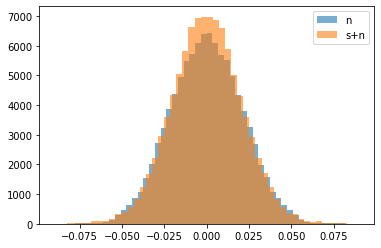

In [12]:
plt.hist(results_n_25, bins=50, alpha=0.6, label="n")
plt.hist(results_s_25, bins=50, alpha=0.6, label = "s+n")
plt.legend()
plt.show()
plt.close()

In [8]:
data1 = np.loadtxt(os.path.join(data_dir, f"test_results_test_signal_1_{nfrq}_{nphi}_S1.csv"))  
best_values = np.where(data1[:,2] == np.max(data1[:,2]))
print("Best value of f = {0:.3f}Hz".format(data1[:,0][best_values][0]))
print("Best Values of p = {0:.3f}".format(data1[:,1][best_values][0]))
print("Maximum Value       = {0:.3f} ({0:.8f})".format(data1[:,2][best_values][0]))
print("\n")

Best value of f = 56.256Hz
Best Values of p = 4.443
Maximum Value       = 0.081 (0.08111650)




In [13]:
def find_parameter(inFile,outFile,tbank,t,mode):
    #prober(inputFile=inFile, outputFile=outFile, template=tbank, mod=mode)
    data = np.loadtxt(os.path.join(data_dir, outFile))
    
    if mode == 2:
        best = np.where(data[:,2] == np.min(data[:,2]))
        print("Minimum value is at f = {0:.3f}Hz".format(data[:,0][best][0]))
        print("Minimum value is at phi = {0:.3f}".format(data[:,1][best][0]))
        print("Minimum Value       = {0:.3f} ({0:.8f})".format(data[:,2][best][0]))
    else:
        best = np.where(data[:,2] == np.max(data[:,2]))
        s = data[:,2]
        s_best = data[:,2][best][0]
        if s_best >= t:
            print("Signal is detected")
            print("Signal is present at f = {0:.3f}Hz".format(data[:,0][best][0]))
            print("Signal is present at p = {0:.3f}".format(data[:,1][best][0]))
            print("Maximum Value       = {0:.3f} ({0:.8f})".format(data[:,2][best][0]))
            print("The value of S is >= the threshold",len(np.where(s >= t)[0]),"times.")
            print(data[np.where(s >= t)[0]])
            #print(data[np.where(s >= t)[0]][:,0])
            print("\n")
            result = "positive"
        elif s_best < t:
            print("Signal is not detected")
            print("Maximum is at f = {0:.3f}Hz".format(data[:,0][best][0]))
            print("Maximum is at p = {0:.3f}".format(data[:,1][best][0]))
            print("Maximum Value       = {0:.3f} ({0:.8f})".format(data[:,2][best][0]))
            print("\n")
            result = "negative"
            
    return result, s_best

In [17]:
s_list_signal = []
s_all_signal = []

number_of_files = 0

nfrq = 1000
nphi = 100
#frq = np.linspace(0.0, 1000.0, nfrq)
#phi = np.linspace(0, 2*np.pi, nphi)

#with open(f"{data_dir}/temp_bank_{nfrq}_{nphi}.csv", "w") as file:
    #for i in range(nfrq):
        #for j in range(nphi):
            #file.write("{0} {1}\n".format(frq[i], phi[j]))

for i in range(1,6):
    print(f"data_0{i}.csv")
    for k in range(10):
        print(f"prober_results_data0{i}_{k}00-{k+1}00_1000_100_S1.csv")
        result, s_value = find_parameter(inFile=f"data_0{i}.csv", outFile=f"prober_results_data0{i}_{k}00-{k+1}00_1000_100_S1.csv", tbank=f"temp_bank_{nfrq}_{nphi}.csv", mode=1, t=0.08)
        if result == "positive":
            s_list_signal = np.append(s_list_signal,s_value)
            number_of_files = number_of_files + 1
        s_all_signal = np.append(s_all_signal,s_value)

print(s_list_signal)
print("Number of files where a signal is present:",number_of_files)

data_01.csv
prober_results_data01_000-100_1000_100_S1.csv
Signal is detected
Signal is present at f = 57.958Hz
Signal is present at p = 3.681
Maximum Value       = 0.090 (0.08982260)
The value of S is >= the threshold 18 times.
[[49.4494     1.07893    0.0801139]
 [49.4494     1.1424     0.0803945]
 [49.4494     1.20586    0.0803525]
 [57.958      3.23679    0.0808695]
 [57.958      3.30026    0.0831864]
 [57.958      3.36373    0.0851684]
 [57.958      3.42719    0.0868076]
 [57.958      3.49066    0.0880955]
 [57.958      3.55413    0.0890329]
 [57.958      3.61759    0.0896079]
 [57.958      3.68106    0.0898226]
 [57.958      3.74452    0.0896739]
 [57.958      3.80799    0.0891697]
 [57.958      3.87146    0.0883034]
 [57.958      3.93492    0.0870821]
 [57.958      3.99839    0.085505 ]
 [57.958      4.06186    0.0835916]
 [57.958      4.12532    0.0813371]]


prober_results_data01_100-200_1000_100_S1.csv
Signal is detected
Signal is present at f = 169.670Hz
Signal is present at 

Signal is not detected
Maximum is at f = 786.687Hz
Maximum is at p = 4.823
Maximum Value       = 0.074 (0.07376320)


prober_results_data03_800-900_1000_100_S1.csv
Signal is not detected
Maximum is at f = 843.143Hz
Maximum is at p = 2.729
Maximum Value       = 0.073 (0.07330170)


prober_results_data03_900-1000_1000_100_S1.csv
Signal is detected
Signal is present at f = 911.211Hz
Signal is present at p = 5.331
Maximum Value       = 0.084 (0.08426830)
The value of S is >= the threshold 10 times.
[[9.11211e+02 5.01385e+00 8.08548e-02]
 [9.11211e+02 5.07732e+00 8.22059e-02]
 [9.11211e+02 5.14079e+00 8.32270e-02]
 [9.11211e+02 5.20425e+00 8.39132e-02]
 [9.11211e+02 5.26772e+00 8.42582e-02]
 [9.11211e+02 5.33119e+00 8.42683e-02]
 [9.11211e+02 5.39465e+00 8.39353e-02]
 [9.11211e+02 5.45812e+00 8.32673e-02]
 [9.11211e+02 5.52159e+00 8.22622e-02]
 [9.11211e+02 5.58505e+00 8.09272e-02]]


data_04.csv
prober_results_data04_000-100_1000_100_S1.csv
Signal is detected
Signal is present at f = 7.608

Signal is not detected
Maximum is at f = 598.999Hz
Maximum is at p = 1.079
Maximum Value       = 0.076 (0.07644590)


prober_results_data05_600-700_1000_100_S1.csv
Signal is not detected
Maximum is at f = 623.023Hz
Maximum is at p = 5.141
Maximum Value       = 0.076 (0.07553660)


prober_results_data05_700-800_1000_100_S1.csv
Signal is detected
Signal is present at f = 791.291Hz
Signal is present at p = 4.506
Maximum Value       = 0.087 (0.08747210)
The value of S is >= the threshold 21 times.
[[7.46847e+02 4.82346e+00 8.07165e-02]
 [7.46847e+02 4.88692e+00 8.11693e-02]
 [7.46847e+02 4.95039e+00 8.12961e-02]
 [7.46847e+02 5.01385e+00 8.10968e-02]
 [7.46847e+02 5.07732e+00 8.05694e-02]
 [7.87487e+02 1.20586e+00 8.00039e-02]
 [7.87487e+02 1.26933e+00 8.03208e-02]
 [7.87487e+02 1.33280e+00 8.03109e-02]
 [7.91291e+02 4.12532e+00 8.12270e-02]
 [7.91291e+02 4.18879e+00 8.31208e-02]
 [7.91291e+02 4.25226e+00 8.46812e-02]
 [7.91291e+02 4.31572e+00 8.59022e-02]
 [7.91291e+02 4.37919e+00 8.67741

In [18]:
s_list_noise = []
s_all_noise = []

number_of_files = 0

nfrq = 1000
nphi = 100
#frq = np.linspace(0.0, 1000.0, nfrq)
#phi = np.linspace(0, 2*np.pi, nphi)

#with open(f"{data_dir}/temp_bank_{nfrq}_{nphi}.csv", "w") as file:
    #for i in range(nfrq):
        #for j in range(nphi):
            #file.write("{0} {1}\n".format(frq[i], phi[j]))

for i in range(1,6):
    print(f"noise_0{i}.csv")
    for k in range(10):
        print(f"prober_results_noise0{i}_{k}00-{k+1}00_1000_100_S1.csv")
        result, s_value = find_parameter(inFile=f"noise_0{i}.csv", outFile=f"prober_results_noise0{i}_{k}00-{k+1}00_1000_100_S1.csv", tbank=f"temp_bank_{nfrq}_{nphi}.csv", mode=1, t=0.08)
        if result == "positive":
            s_list_noise = np.append(s_list_noise,s_value)
            number_of_files = number_of_files + 1
        s_all_noise = np.append(s_all_noise,s_value)

print(s_list_noise)
print("Number of files where a signal is present:",number_of_files)

noise_01.csv
prober_results_noise01_000-100_1000_100_S1.csv
Signal is detected
Signal is present at f = 36.637Hz
Signal is present at p = 0.381
Maximum Value       = 0.085 (0.08483390)
The value of S is >= the threshold 11 times.
[[36.6366     0.0634665  0.0806409]
 [36.6366     0.126933   0.0821524]
 [36.6366     0.1904     0.083329 ]
 [36.6366     0.253866   0.0841684]
 [36.6366     0.317333   0.0846723]
 [36.6366     0.380799   0.0848339]
 [36.6366     0.444266   0.0846555]
 [36.6366     0.507732   0.0841345]
 [36.6366     0.571199   0.0832744]
 [36.6366     0.634665   0.0820798]
 [36.6366     0.698132   0.0805556]]


prober_results_noise01_100-200_1000_100_S1.csv
Signal is detected
Signal is present at f = 121.021Hz
Signal is present at p = 1.396
Maximum Value       = 0.080 (0.08044320)
The value of S is >= the threshold 4 times.
[[1.21021e+02 1.26933e+00 8.00168e-02]
 [1.21021e+02 1.33280e+00 8.03921e-02]
 [1.21021e+02 1.39626e+00 8.04432e-02]
 [1.21021e+02 1.45973e+00 8.01688e-02

Signal is not detected
Maximum is at f = 626.727Hz
Maximum is at p = 0.698
Maximum Value       = 0.080 (0.07964810)


prober_results_noise03_700-800_1000_100_S1.csv
Signal is not detected
Maximum is at f = 739.239Hz
Maximum is at p = 0.190
Maximum Value       = 0.072 (0.07198800)


prober_results_noise03_800-900_1000_100_S1.csv
Signal is not detected
Maximum is at f = 847.147Hz
Maximum is at p = 0.952
Maximum Value       = 0.079 (0.07933140)


prober_results_noise03_900-1000_1000_100_S1.csv
Signal is detected
Signal is present at f = 942.142Hz
Signal is present at p = 0.317
Maximum Value       = 0.088 (0.08779520)
The value of S is >= the threshold 14 times.
[[9.42142e+02 0.00000e+00 8.38621e-02]
 [9.42142e+02 6.34665e-02 8.53439e-02]
 [9.42142e+02 1.26933e-01 8.64820e-02]
 [9.42142e+02 1.90400e-01 8.72728e-02]
 [9.42142e+02 2.53866e-01 8.77087e-02]
 [9.42142e+02 3.17333e-01 8.77952e-02]
 [9.42142e+02 3.80799e-01 8.75276e-02]
 [9.42142e+02 4.44266e-01 8.69054e-02]
 [9.42142e+02 5.07732

Signal is not detected
Maximum is at f = 531.031Hz
Maximum is at p = 5.014
Maximum Value       = 0.069 (0.06860710)


prober_results_noise05_600-700_1000_100_S1.csv
Signal is detected
Signal is present at f = 654.354Hz
Signal is present at p = 2.539
Maximum Value       = 0.085 (0.08456890)
The value of S is >= the threshold 10 times.
[[6.54354e+02 2.28479e+00 8.12946e-02]
 [6.54354e+02 2.34826e+00 8.26162e-02]
 [6.54354e+02 2.41173e+00 8.36060e-02]
 [6.54354e+02 2.47519e+00 8.42559e-02]
 [6.54354e+02 2.53866e+00 8.45689e-02]
 [6.54354e+02 2.60213e+00 8.45411e-02]
 [6.54354e+02 2.66559e+00 8.41734e-02]
 [6.54354e+02 2.72906e+00 8.34658e-02]
 [6.54354e+02 2.79253e+00 8.24235e-02]
 [6.54354e+02 2.85599e+00 8.10459e-02]]


prober_results_noise05_700-800_1000_100_S1.csv
Signal is not detected
Maximum is at f = 726.126Hz
Maximum is at p = 0.444
Maximum Value       = 0.072 (0.07203640)


prober_results_noise05_800-900_1000_100_S1.csv
Signal is detected
Signal is present at f = 809.109Hz
Signa

In [19]:
results_n_25 = []
results_s_25 = []

for i in range(1,6):
    for k in range(10):
        data1 = np.loadtxt(os.path.join(data_dir, f"prober_results_noise0{i}_{k}00-{k+1}00_1000_100_S1.csv"))  
        data2 = np.loadtxt(os.path.join(data_dir, f"prober_results_data0{i}_{k}00-{k+1}00_1000_100_S1.csv"))
        results_n_25 = np.append(results_n_25,data1[:,2])
        results_s_25 = np.append(results_s_25,data2[:,2])

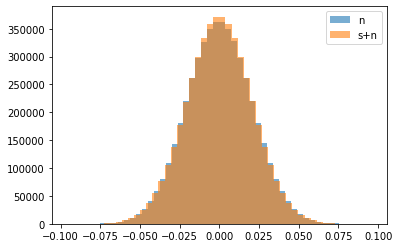

In [20]:
plt.hist(results_n_25, bins=50, alpha=0.6, label="n")
plt.hist(results_s_25, bins=50, alpha=0.6, label = "s+n")
plt.legend()
plt.show()
plt.close()

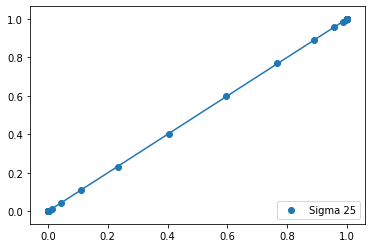

In [26]:
#FP_25 = []
#TP_25 = []

#for t in np.linspace(-1,1,200):
    #FP_25 = np.append(FP_25,len(np.where(results_n_25 >= t)[0])/len(results_n_25))
    #TP_25 = np.append(TP_25,len(np.where(results_s_25 >= t)[0])/len(results_s_25))

FP_25 = [ 1.0 * len(np.where(results_n_25 >= t)[0]) / len(results_n_25) for t in np.linspace(-1, 1, 200)]    
TP_25 = [ 1.0 * len(np.where(results_s_25 >= t)[0]) / len(results_s_25) for t in np.linspace(-1, 1, 200)]    
    
    
plt.scatter(FP_25,TP_25,label="Sigma 25")
plt.legend(loc="lower right")
plt.plot([0,1])
plt.show()
plt.close()

In [22]:
print(len(np.where(results_n_25 >= 0.08)[0]))
print(len(results_n_25))

255
5000000


In [43]:
def search_f_ph(datafile, freq=None, phase=None, N_df=100, f_min=0.01, f_max=20, mod=1, N_ph=50, title=None):
    # Make a frequency space from 0.01 to f_max with N_df steps
    #freqs = np.linspace(f_min, f_max, N_df) 
    #phases = np.linspace(0, 2*m.pi, N_ph)

    #tbank = "tb_test_fphi.tb" # can parametrise this later
    
    # Generate template bank with this frequency space
    # You can also add phase space if feeling like doing a 3D plot
    #with open(os.path.join(data_dir,tbank) ,'w') as tbfile:
        #for f in freqs:
            #for ph in phases:
                #tbfile.write("{0} {1}\n".format(f,ph))

    #results_file = prober(datafile, outputFile=f"results_test_signal_{i}_{nfrq}_{nphi}_S1.csv", template=f"temp_bank_{nfrq}_{nphi}.csv", mode=1)
    results = np.loadtxt(os.path.join(data_dir, f"results_test_signal_2_1000_100_S1.csv"))
    
    # Plotting
    plt.figure(figsize=(15,4))
    if mod == 3:
        ### This is justa Fourier transform, template bank ignored 1/N frequencies tested
        best = np.where(results[:,2] == np.max(results[:,2]))
        plt.plot(results[:,0], results[:,2])
        plt.xscale('log')
        plt.xlabel("f [Hz]")
        plt.show()
        plt.close()
        
        #print(results[:,0][best][0], 0, results[:,2][best][0])
        
        return (results[:,0][best][0], 0, results[:,2][best][0])
    
    levels = np.linspace(np.min(results[:,2]),np.max(results[:,2]),50)
    CS = plt.contourf(results[:,0].reshape(N_df,N_ph),results[:,1].reshape(N_df,N_ph),results[:,2].reshape(N_df,N_ph),levels)
    
    if (freq and phase):
        plt.scatter(freq,phase,marker="x", label="Injection point")
    
    # Plot best match
    if mod == 1 :
        # For S_1 get the maximum
        plt.scatter(results[np.argmax(results[:,2])][0], results[np.argmax(results[:,2])][1], marker="o", label="Loudest point")
        best_phi, best_f, best_val = results[np.argmax(results[:,2])]
    elif mod == 2: 
        # For S_2 get the minimum
        plt.scatter(results[np.argmin(results[:,2])][0], results[np.argmin(results[:,2])][1], marker="o", label="Loudest point")
        best_phi, best_f, best_val = results[np.argmin(results[:,2])]
        
    plt.title(f"Searching over frequency and phase - 2D search $S_{mod}$")
    plt.legend(loc='best')
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Phase")
    plt.colorbar(CS, label="Prober output")
    plt.show()
    plt.close()
    
    ### Caluclate amplitude (look at data at peak)
    print(best_phi, best_f, best_val)
    
    return (best_phi, best_f, best_val)

In [46]:
def task5(iFile, oFile, mode):          
    nfrq = 1000
    nphi = 100
    #freq = np.linspace(0.01, 1000.0, nfrq)
    #phi = np.linspace(0, 2*np.pi, nphi)

    #with open(f"{data_dir}/temp_bank_task5.csv", "w") as file:
        #for i in range(nfrq):
            #for j in range(nphi):
                #file.write("{0} {1}\n".format(freq[i], phi[j]))
                
    #prober(inputFile=iFile, outputFile=oFile, template="temp_bank_task5.csv", mod=mode)
    
    data = np.loadtxt(os.path.join(data_dir, oFile))
   
    plt.figure(figsize=(15,4))

    if mode == 3:
        plt.plot(data[:,0],data[:,2])
    else:
        f = data[:,0]
        p = data[:,1]
        S = data[:,2]
        S = np.reshape(S, (nfrq,nphi))
        f = np.reshape(f, (nfrq,nphi))
        p = np.reshape(p, (nfrq,nphi))
        plt.contourf(f,p,S)
        plt.colorbar()
    
    #S_2 searching for the minimum value
    if mode == 2:
        plt.scatter(data[np.argmin(data[:,2])][0], data[np.argmin(data[:,2])][1], marker="o", label="Loudest point")
        best = np.where(data[:,2] == np.min(data[:,2]))
        #print("Frequency  f = {0:.3f}Hz".format(freq))
        print("Minimum value is at f = {0:.3f}Hz".format(data[:,0][best][0]))
        print("Minimum value is at phi = {0:.3f}".format(data[:,1][best][0]))
        print("Minimum Value       = {0:.3f} ({0:.8f})".format(data[:,2][best][0]))
    else:
        plt.scatter(data[np.argmax(data[:,2])][0], data[np.argmax(data[:,2])][1], marker="o", label="Loudest point")
        best = np.where(data[:,2] == np.max(data[:,2]))
        #print("Frequency  f = {0:.3f}Hz".format(freq))
        print("Maximum value is at f = {0:.3f}Hz".format(data[:,0][best][0]))
        print("Maximum value is at phi = {0:.3f}".format(data[:,1][best][0]))
        print("Maximum Value       = {0:.3f} ({0:.8f})".format(data[:,2][best][0]))
        


Maximum value is at f = 115.115Hz
Maximum value is at phi = 2.856
Maximum Value       = 0.082 (0.08169110)


(105.115, 125.115)

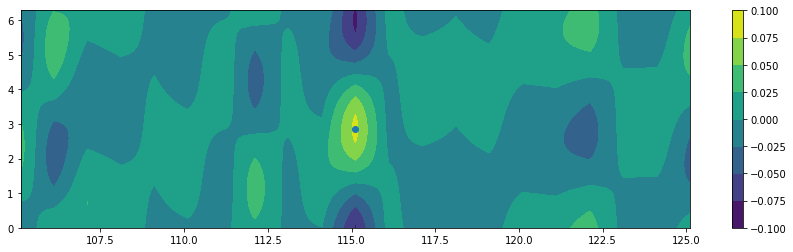

In [50]:
task5(iFile=f"test_signal_2.csv", oFile=f"results_test_signal_2_1000_100_S1.csv", mode=1)
plt.xlim([105.115, 125.115])

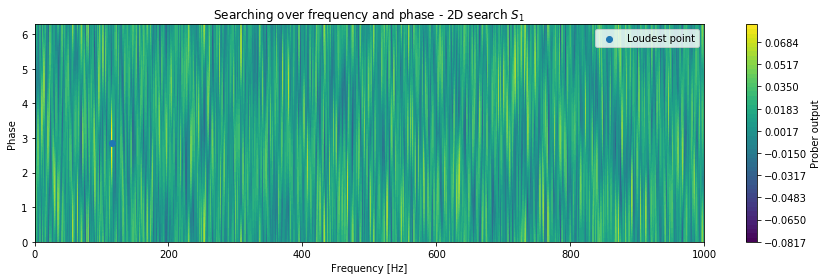

115.115 2.85599 0.0816911


(115.115, 2.85599, 0.0816911)

In [44]:
search_f_ph(f"test_signal_2.csv", freq=None, phase=None, N_df=1000, f_min=0.01, f_max=1000, mod=1, N_ph=100, title=None)
#plt.xlim([550.0, 650.0])

In [42]:
def get_mismatch(datafile, freq=None, N_df=300, f_min=0.5, f_max=100.5, mod=1):
    # Make a frequency space from 0.01 to f_max with N_df steps
    # This time try to minimise the number of templates in the bank
    # such that you still get good detection
    freqs = np.linspace(f_min, f_max, N_df) 
    tbank = "tb_mismatch.tb" 
    
    # Generate template bank with this frequency space
    with open(os.path.join(data_dir,tbank) ,'w') as tbfile:
        for f in freqs:
            tbfile.write("{0} {1}\n".format(f,0))

    results_file = prober(datafile, templateFile=tbank, mod=mod)
    results = np.loadtxt(results_file)
    
    if mod == 3:
        best = np.where(results[:,2] == np.max(results[:,2]))
        resultsf_tv = prober(datafile, f=freq, mod=3)
        results_tv = np.loadtxt(resultsf_tv)
        S_best = results[:,2][best][0]
        S_tv = np.max(results_tv)
        M_i = 1 - (S_best/S_tv)
        
        return M_i
    
    # Plot best match
    if mod == 1 :
        # For S_1 get the maximum
        best_phi, best_f, best_val = results[np.argmax(results[:,2])]
        tv_phi, tv_f, tv_val = prober(datafile, f=freq, mod=1)
        M_i = 1 - float(best_val)/float(tv_val)
    elif mod == 2: 
        best_phi, best_f, best_val = results[np.argmin(results[:,2])]
        tv_phi, tv_f, tv_val = prober(datafile, f=freq, mod=2)
        M_i = 1 - abs(float(tv_val)-float(best_val)/float(tv_val))
        

    return M_i

[-0.0816917  -0.07605781 -0.07042392 -0.06479003 -0.05915614 -0.05352225
 -0.04788836 -0.04225447 -0.03662058 -0.03098669 -0.0253528  -0.01971891
 -0.01408502 -0.00845113 -0.00281724  0.00281664  0.00845053  0.01408442
  0.01971831  0.0253522   0.03098609  0.03661998  0.04225387  0.04788776
  0.05352165  0.05915554  0.06478943  0.07042332  0.07605721  0.0816911 ]


In [ ]:
s_list_signal = []
s_all_signal = []

number_of_files = 0

nfrq = 1000
nphi = 100
#frq = np.linspace(0.0, 1000.0, nfrq)
#phi = np.linspace(0, 2*np.pi, nphi)

#with open(f"{data_dir}/temp_bank_{nfrq}_{nphi}.csv", "w") as file:
    #for i in range(nfrq):
        #for j in range(nphi):
            #file.write("{0} {1}\n".format(frq[i], phi[j]))

for i in range(1,6):
    result, s_value = find_parameter(inFile=f"data_0{i}.csv", outFile=f"results_signal_{i}.csv", tbank=f"temp_bank_{nfrq}_{nphi}.csv", mode=1, t=0.08)
    if result == "positive":
        s_list_signal = np.append(s_list_signal,s_value)
        number_of_files = number_of_files + 1
    s_all_signal = np.append(s_all_signal,s_value)

print(s_list_signal)
print("Number of files where a signal is present:",number_of_files)